# Classification - part 2

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set() #sets the matplotlib style to seaborn style

from scipy.io import loadmat 
from scipy.ndimage import convolve1d
from scipy.signal import butter
from scipy.signal import sosfiltfilt
from scipy.signal import welch
import pandas as pd

In the previous exercise, we performed classification and we managed achieved decent results. This week, we will use a Ninapro dataset to explore machine learning concepts to better evaluate our model and feature selections methods.

Now, lets load the data and start with a simple classification.

In [6]:
data = loadmat('exercise_1__dataset_1.mat')
emg = data['emg']
stimulus = data['restimulus']
repetition = data['rerepetition']

Same as week 10, for each trial (one repetition of one stimulus) we create a nested list of envelopes of the trials.

In [7]:
n_stimuli = len(np.unique(stimulus)) - 1 # -1 because 0 is the resting condition
n_repetitions = len(np.unique(repetition)) - 1 # -1 because 0 is not a repetition

mov_mean_length = 25
mov_mean_weights = np.ones(mov_mean_length) / mov_mean_length

#initializing the data structure
emg_windows = [[None for j in range(n_repetitions)] for i in range(n_stimuli)]
emg_rectified = [[None for j in range(n_repetitions)] for i in range(n_stimuli)]
emg_envelopes = [[None for j in range(n_repetitions)] for i in range(n_stimuli)]

for i in range(n_stimuli):
    for j in range(n_repetitions):
        idx = np.logical_and(stimulus == i + 1, repetition == j + 1).flatten()
        emg_windows[i][j] = emg[idx, :]
        emg_rectified[i][j] = np.abs(emg_windows[i][j])
        # emg_rectified = np.abs(emg_windows[i][j])
        emg_envelopes[i][j] = convolve1d(emg_rectified[i][j], mov_mean_weights, axis=0)

Then, using the provided code, we extract the features. In this simple example we will look at mean and standard deviation within the full window of each trial. Feel free to add in more features learnt last week that you think can be useful.

In [12]:
def build_dataset_from_ninapro(emg, stimulus, repetition, features=None):
    n_stimuli = np.unique(stimulus).size - 1
    n_repetitions = np.unique(repetition).size - 1
    n_samples = n_stimuli * n_repetitions
    
    n_channels = emg.shape[1]
    n_features = 0
    if "mean" in features:
        n_features += n_channels
    if "std" in features:
        n_features += n_channels
    
    dataset = np.zeros((n_samples, n_features))
    labels = np.zeros(n_samples)
    current_sample_index = 0
    for i in range(n_stimuli):
        for j in range(n_repetitions):
            labels[current_sample_index] = i + 1
            current_feature_index = 0
            selected_tsteps = np.logical_and(stimulus == i + 1, repetition == j + 1).squeeze()
            
            if "mean" in features:
                selected_features = np.arange(current_feature_index, current_feature_index + n_channels)
                dataset[current_sample_index, selected_features] = np.mean(emg[selected_tsteps, :], axis=0)
                current_feature_index += n_channels
            if "std" in features:
                selected_features = np.arange(current_feature_index, current_feature_index + n_channels)
                dataset[current_sample_index, selected_features] = np.std(emg[selected_tsteps, :], axis=0)
                current_feature_index += n_channels

            current_sample_index += 1
            
    return dataset, labels

In [13]:
dataset, labels = build_dataset_from_ninapro(
    emg=emg,
    stimulus=stimulus,
    repetition=repetition,
    features=["mean", "std"]
)
X = dataset
y = labels

print(X.shape)
print(y.shape)

(120, 20)
(120,)


Since we have 12 actions and 10 repeats for each actions, we have a total of 120 training examples. This is a small classification problem.

Now, lets apply the classification techniques we learnt last week.


0.6388888888888888


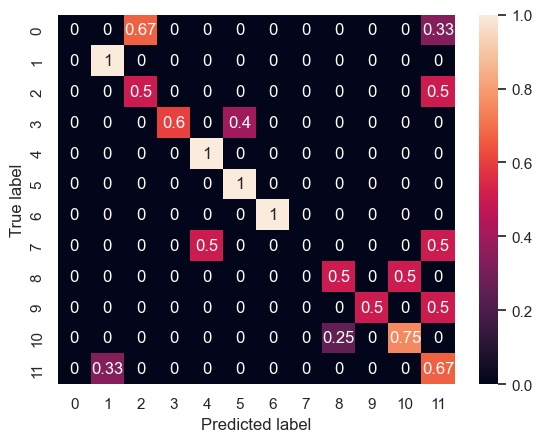

In [10]:
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
import seaborn as sns

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

#normalizing the data
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_z = scaler.fit_transform(X_train)
X_test_z = scaler.transform(X_test)

# train a classifier on the normalized data
clf = SVC()
clf.fit(X_train_z, y_train)

# evaluate the classifier on the test set
y_pred = clf.predict(X_test_z)
accuracy = accuracy_score(y_test, y_pred)
print(accuracy)

confmat = confusion_matrix(y_test, y_pred, normalize="true")
fig, ax = plt.subplots()
sns.heatmap(confmat, annot=True, ax=ax)
ax.set_ylabel("True label")
ax.set_xlabel("Predicted label");

## Cross-validation for evaluation

In the previous example, we used a random method to split the data into training and testing sets. It's important to note that the model's performance can vary significantly depending on this split. 

Therefore, in our next step, we plan to vary the composition of the training and testing datasets and train multiple models accordingly. This approach is known as cross-validation, and it helps in assessing the model's effectiveness more reliably by using different data subsets for training and testing.

In [11]:
# perform cross-validation
from sklearn.model_selection import cross_val_score
scores = ???
print(scores)
print(np.mean(scores))

SyntaxError: invalid syntax (3302574497.py, line 3)

In the above code, the 5 different model is trained and evaluated. Each model is trained on a different training and testing set. We see that depending on how the data is split, the performance could vary from 0.64 to 0.76. Hence, we can then use the average performance for our evaluation.

## Hyperparameter optimization

Something that we can do to improve classification is also to optimize the parameters of the models. For instance, in the SVC function on sklearn, we have the option to select various values for 'C', 'gamma', and the kernel. To effectively test the different combinations of these parameters, we can utilize the GridSearchCV function of sklearn, which is designed to methodically identify the optimal combination of these parameters, thereby ensuring the best possible performance and accuracy for the model.

In [ ]:
# use cross validation to find the best hyperparameters for SVC

from sklearn.model_selection import GridSearchCV

param_grid = {
    "C": [0.1, 1, 10, 100],
    "gamma": [1, 0.1, 0.01, 0.001],
    "kernel": ["rbf", "poly", "sigmoid"]
}

grid = ???
grid.fit(X_train_z, y_train)

print(grid.best_estimator_)
print(grid.best_params_)

y_pred = grid.predict(X_test_z)

accuracy = accuracy_score(y_test, y_pred)
print(accuracy)



We see how the accuracy increased by searching for the best parameters. 

# Feature importance/selection

In this example, we are dealing with a relatively small set of 20 features, comprising the mean and standard deviation of each channel. However, in scenarios like exercise 11, where we encounter a larger number of features, it can be important to employ feature selection techniques to improve model performance and efficiency. 

For this purpose, we propose a method that utilizes functions like mutual_info_classif and SelectKBest from sklearn. mutual_info_classif evaluates the mutual information between each feature and the target variable, providing an insight into the relevance of each feature. Meanwhile, SelectKBest allows us to select a specified number of features that have the highest scores according to a given scoring function, in this case, the mutual information. By combining these two functions, we can effectively reduce the feature space to those most relevant.

In [ ]:
from sklearn.feature_selection import mutual_info_classif
from sklearn.feature_selection import SelectKBest

mutual_info = ???
print(mutual_info)

k_best = ???
k_best.fit(X_train_z, y_train)

X_train_best = k_best.transform(X_train_z)
X_test_best = k_best.transform(X_test_z)

clf = SVC(**grid.best_params_) # use the best parameters found before
clf.fit(X_train_best, y_train)

y_pred = clf.predict(X_test_best)
accuracy = accuracy_score(y_test, y_pred)
print(accuracy)

confmat = confusion_matrix(y_test, y_pred, normalize="true")

fig, ax = plt.subplots()
sns.heatmap(confmat, annot=True, ax=ax)
ax.set_ylabel("True label")
ax.set_xlabel("Predicted label")
